In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
import seaborn as sns

/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/mdshare/repository.py:53: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = load(fh)


## Data loading

In [6]:
# Constants
HEAD_STEP = 250

In [7]:
# coordinate file lists
p_main = Path('../')
p_extension = Path('../../../extension/acd')
traj_files_main = list(p_main.glob('2019*/production_dry.nc'))
traj_files_extension = list(p_extension.glob('2019*/extension_dry.nc'))

In [8]:
traj_files_main = [file.as_posix() for file in traj_files_main]
traj_files_extension = [file.as_posix() for file in traj_files_extension]

In [9]:
# define features
feat_pep1 = pyemma.coordinates.featurizer('./repo/stripped.initial_wat_ion.parm7') 
feat_pep1.add_backbone_torsions(selstr='resid 0 to 41', periodic=True)

# data loading
data_pep1_main = pyemma.coordinates.load(traj_files_main[:], features=feat_pep1)
data_pep1_extension = pyemma.coordinates.load(traj_files_extension[:], features=feat_pep1)

# truncate trajectories
data_pep1_main_truncated = [i[HEAD_STEP:] for i in data_pep1_main]
data_pep1 = data_pep1_main_truncated + data_pep1_extension

In [10]:
# define features
feat_pep2 = pyemma.coordinates.featurizer('./repo/stripped.initial_wat_ion.parm7') 
feat_pep2.add_backbone_torsions(selstr='resid 42 to 83', periodic=True)

# data loading
data_pep2_main = pyemma.coordinates.load(traj_files_main[:], features=feat_pep2)
data_pep2_extension = pyemma.coordinates.load(traj_files_extension[:], features=feat_pep2)

# truncate trajectories
data_pep2_main_truncated = [i[HEAD_STEP:] for i in data_pep2_main]
data_pep2 = data_pep2_main_truncated + data_pep2_extension

In [11]:
data = data_pep1 + data_pep2
# data = data_pep1[:401] + data_pep2[:401]
len(data)

812

In [12]:
data_concatenated = np.concatenate(data)
data_concatenated.shape

(373248, 82)

In [72]:
# fig, ax = plt.subplots(figsize=(6, 40))
# pyemma.plots.plot_feature_histograms(data_concatenated, ax=ax, feature_labels=feat)
# plt.show()

## Dimension reduction

In [103]:
vamp = pyemma.coordinates.vamp(data, lag=60)
vamp

VAMP(dim=None, epsilon=1e-06, lag=60, ncov_max=inf, right=False, scaling=None,
   skip=0, stride=1)

In [104]:
print(len(vamp.get_output()))
print(vamp.get_output()[0].shape)

812


(250, 82)


In [105]:
vamp_concatenated = np.concatenate(vamp.get_output())
vamp_concatenated

array([[ 0.10018508,  0.9764582 ,  1.5838128 , ..., -1.3273138 ,
        -0.71600497, -0.5181847 ],
       [-0.06236665,  1.0439328 ,  1.7035826 , ..., -1.5341982 ,
        -0.576013  , -0.8335674 ],
       [ 0.10863431,  1.0338682 ,  1.4786032 , ..., -1.1229521 ,
        -0.6166064 , -0.62754947],
       ...,
       [-3.2231631 ,  0.27541733,  1.2498536 , ..., -0.51594937,
        -0.78361   ,  1.6552869 ],
       [-3.2104728 ,  0.32168475,  1.167543  , ...,  1.153572  ,
        -1.908232  , -0.16351691],
       [-2.8964374 , -0.45607084,  1.3587286 , ...,  0.35178077,
        -0.29506072,  2.448949  ]], dtype=float32)

Text(0.5, 1.0, 'Acidic')

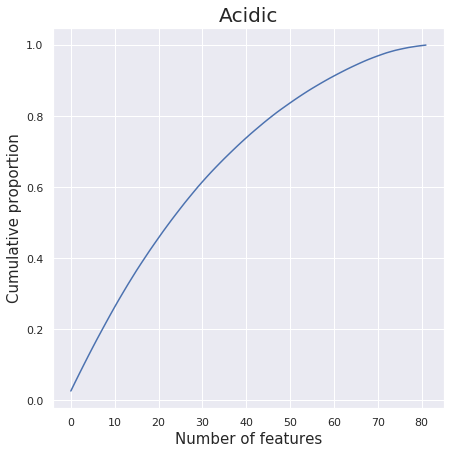

In [106]:
sns.set()
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(vamp.cumvar)
ax.set_xlabel('Number of features', fontsize=15)
ax.set_ylabel('Cumulative proportion', fontsize=15)
ax.set_title('Acidic', fontsize=20)

# plt.savefig('cum_dist_acd.png')

## Clustering

In [107]:
cluster = pyemma.coordinates.cluster_kmeans(vamp.get_output(), k=500, max_iter=50, stride=10)

/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/

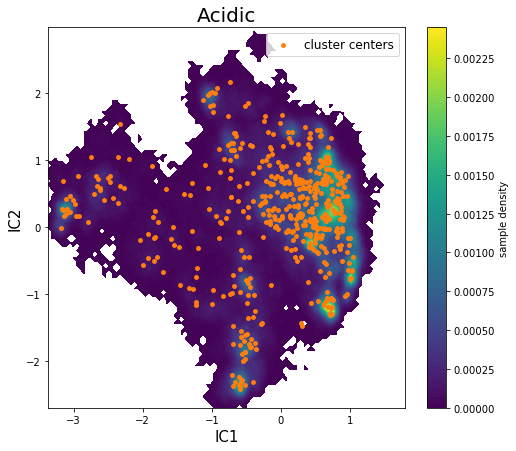

In [108]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(8,7))
pyemma.plots.plot_density(*vamp_concatenated.T[:2], ax=ax, cbar=True)
ax.scatter(*cluster.clustercenters.T[:2], s=15, c='C1', label='cluster centers')
ax.set_xlabel('IC1', fontsize=15)
ax.set_ylabel('IC2', fontsize=15)
ax.set_title('Acidic', fontsize=20)
ax.legend(fontsize=12)

# plt.savefig('vamp_density_map_acd.png')

## MSM construction

In [112]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1, 2, 10, 30, 50, 100, 150], nits=5, errors='bayes')

/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


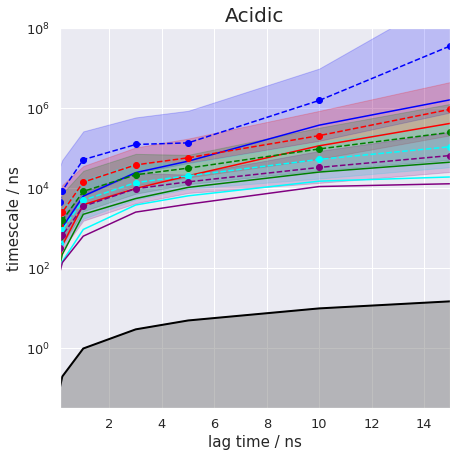

In [119]:
sns.set()

fig, ax = plt.subplots(figsize=(7,7))
pyemma.plots.plot_implied_timescales(its, ylog=True, units='ns', dt=0.1, confidence=0.95)
ax.set_title('Acidic', fontsize=20)
ax.set_ylim(0, 10e7)
plt.gca().xaxis.get_label().set_fontsize(15)
plt.gca().yaxis.get_label().set_fontsize(15)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(13)


# plt.savefig('lag_time_acd.png')

In [80]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=60, dt_traj='100 ps')

In [120]:
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=60, dt_traj='100 ps', conf=0.95, show_progress=True)

In [81]:
msm.active_state_fraction

0.764

In [82]:
msm.active_count_fraction

0.9013470936213992

In [83]:
#bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=60, dt_traj='100 ps', conf=0.95)

## Validation

14-01-20 13:50:34 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[15] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
14-01-20 13:50:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[16] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/estimation/api.py:956: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  result = sparse.mle.mle_trev.mle_trev(C, **kwargs)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/estimation/api.py:956: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  result = sparse.mle.mle_trev.mle_trev(C, **kwargs)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/estimation/api.py:956: NotConvergedWarning: Reversible transition matrix estimation didn't converge.
  result = sparse.mle.mle_trev.mle_trev(C, **kwargs)


/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 378 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 359 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 300 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 238 components
  warnings.warn('truncated eigendecomposition to co

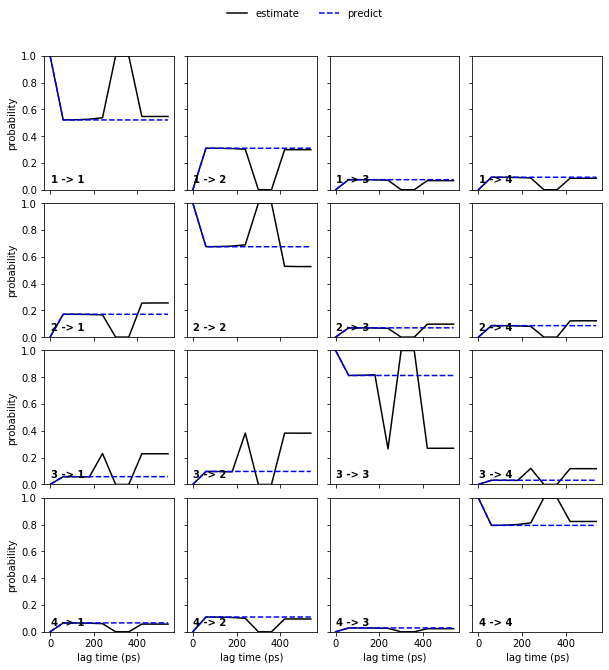

In [37]:
pyemma.plots.plot_cktest(msm.cktest(4), units='ps');

18-01-20 14:42:14 pyemma.msm.estimators.bayesian_msm.BayesianMSM[74] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
18-01-20 14:42:17 pyemma.msm.estimators.bayesian_msm.BayesianMSM[74] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
18-01-20 14:42:20 pyemma.msm.estimators.bayesian_msm.BayesianMSM[75] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration
18-01-20 14:42:20 pyemma.msm.estimators.bayesian_msm.BayesianMSM[74] WARNING  Ignored error during estimation: Stationary distribution contains entries smaller than 1e-15 during iteration


/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:395: RuntimeWarning: invalid value encountered in sqrt
  R = R / np.sqrt(s[np.newaxis, :])
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/dense/decomposition.py:396: RuntimeWarning: invalid value encountered in sqrt
  L = L / np.sqrt(s[np.newaxis, :])
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 380 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 356 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/site-packages/msmtools/analysis/api.py

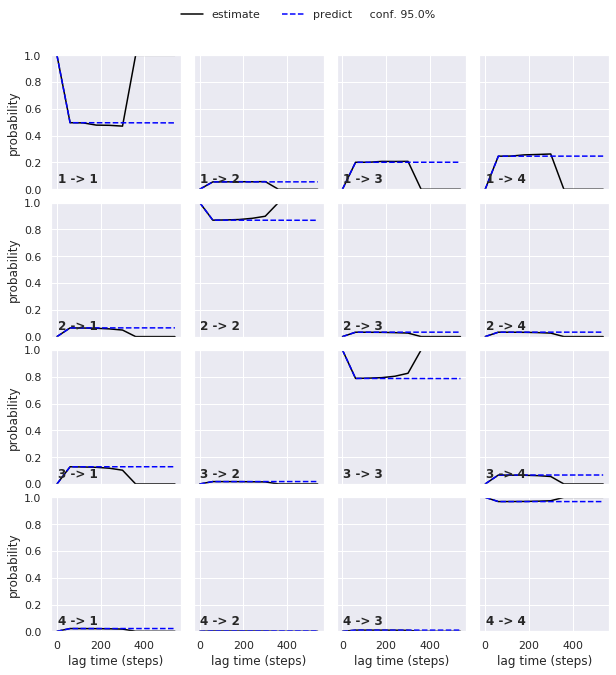

In [121]:
pyemma.plots.plot_cktest(bayesian_msm.cktest(4));

## micro states to macro states

In [93]:
nstates = 3
msm.pcca(nstates)

PCCA(P=array([[0.91057, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.70175, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.67074, 0.     ],
       [0.     , 0.     , ..., 0.     , 0.99474]]),
   m=3)

In [94]:
for i, s in enumerate(msm.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm.pi[s].sum()))

π_1 = 0.073083
π_2 = 0.506319
π_3 = 0.420599


In [95]:
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
dtrajs_concatenated.shape

(373248,)

In [96]:
dtrajs_concatenated_connected = np.array([i for i in dtrajs_concatenated if i <= 380])
dtrajs_concatenated_connected

array([292,  32,  32, ...,  33,  55, 101], dtype=int32)

In [97]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated_connected]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

In [98]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

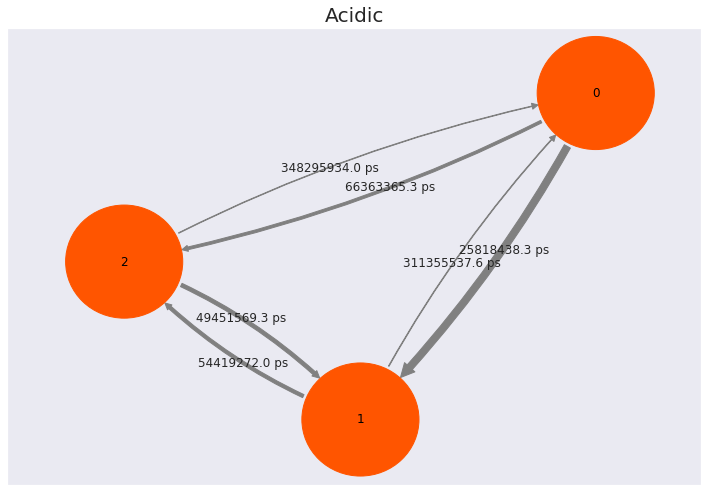

In [100]:
fig, ax = plt.subplots(figsize=(10, 7))
# _, _, misc = pyemma.plots.plot_state_map(
#     *data_concatenated.T, metastable_traj, ax=ax, zorder=-1)
# misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
#     figpadding=0,
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    size=12,
    show_frame=True,
    ax=ax)

ax.set_title('Acidic', fontsize=20)

# ax.set_xlabel('$\Phi$')
# ax.set_ylabel('$\Psi$')
# ax.set_xlim(-np.pi, np.pi)
# ax.set_ylim(-np.pi, np.pi)
fig.tight_layout()

plt.savefig('macrostates_acd.png')

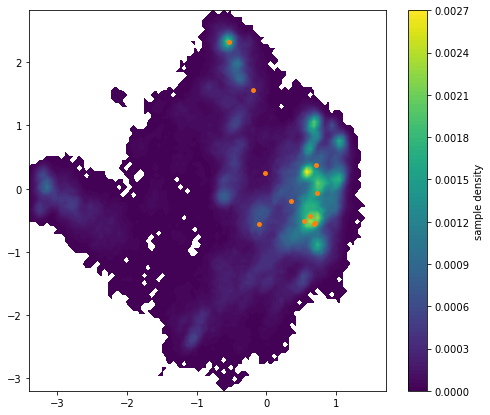

In [50]:
fig, ax = plt.subplots(figsize=(8,7))
pyemma.plots.plot_density(*vamp_concatenated.T[0:2], ax=ax, cbar=True)
ax.scatter(*cluster_centers_state4.T, s=15, c='C1')
plt.show()

## PCAを使った解析

In [14]:
pca = pyemma.coordinates.pca(data, dim=30)

In [15]:
pca_concatenated = np.concatenate(pca.get_output())

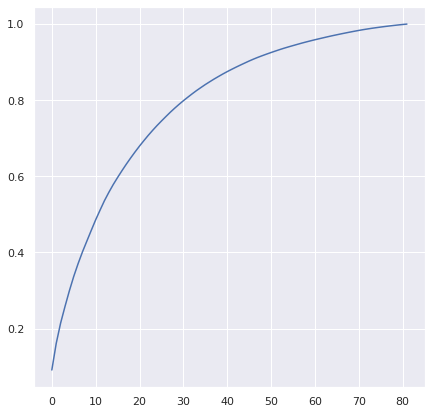

In [16]:
sns.set()
fig, ax = plt.subplots(figsize=(7,7))
plt.plot(range(pca.cumvar.size), pca.cumvar)
plt.show()

In [17]:
cluster = pyemma.coordinates.cluster_kmeans(pca.get_output(), k=500, max_iter=50, stride=10)

In [18]:
its = pyemma.msm.its(cluster.dtrajs, nits=6, errors='bayes')

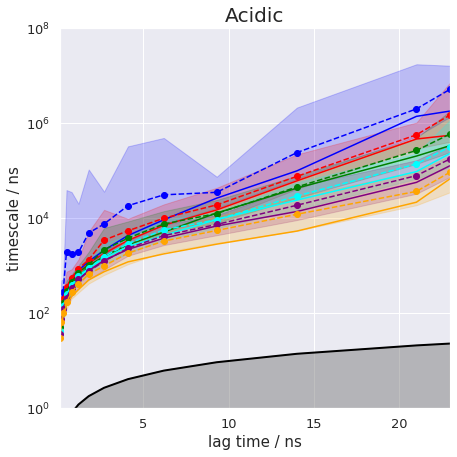

In [19]:
sns.set()

fig, ax = plt.subplots(figsize=(7,7))
pyemma.plots.plot_implied_timescales(its, ylog=True, units='ns', dt=0.1, confidence=0.95)
ax.set_title('Acidic', fontsize=20)
ax.set_ylim(1, 10e7)
plt.gca().xaxis.get_label().set_fontsize(15)
plt.gca().yaxis.get_label().set_fontsize(15)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(13)


# plt.savefig('lag_time_acd.png')

In [20]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=60, dt_traj='100 ps')

In [21]:
msm.active_state_fraction

1.0

In [22]:
msm.active_count_fraction

1.0

In [31]:
cluster_macro = pyemma.coordinates.cluster_kmeans(cluster.dtrajs, k=10, max_itr=1000)

18-01-20 22:37:23 pyemma.coordinates.clustering.kmeans.KmeansClustering[17] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 10 iterations. Consider increasing max_iter.


/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/

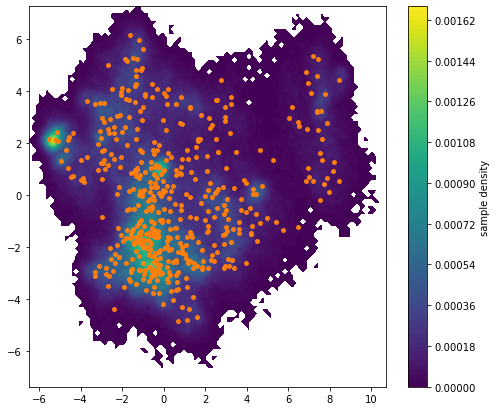

In [36]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(8,7))
pyemma.plots.plot_density(*pca_concatenated.T[:2], ax=ax, cbar=True)
ax.scatter(*cluster.clustercenters.T[:2], c='C1', s=15)

plt.show()

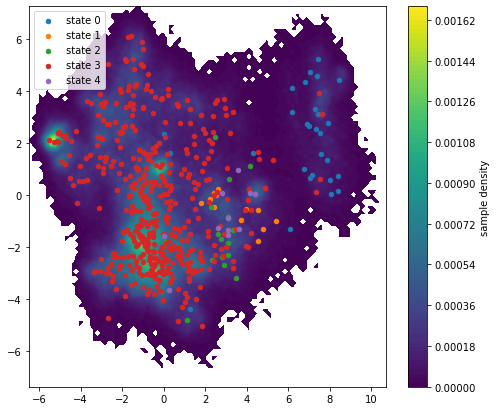

In [339]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(8,7))
pyemma.plots.plot_density(*pca_concatenated.T[:2], ax=ax, cbar=True)
for state in range(n_states):
    ax.scatter(*np.array([coord for i, coord in enumerate(cluster.clustercenters) if i in msm.metastable_sets[state]]).T[:2], s=20, label=f'state {state}')

plt.legend()
plt.show()

In [345]:
!pwd

/home/yuki/mnt/main/acd/analysis


In [359]:
top_path = '/home/yuki/mnt/structure-ini/T-REMD/acd/analysis/prmtop.parm7'
traj_path = '/home/yuki/mnt/structure-ini/T-REMD/acd/analysis/mdcrd.310.nc'

In [357]:
feat_monomer = pyemma.coordinates.featurizer(top_path)

In [358]:
feat_monomer.add_backbone_torsions(selstr='resid 0 to 41', periodic=False)

In [361]:
data_monomer = pyemma.coordinates.load(traj_path, features=feat_monomer)

In [370]:
converted_data_monomer = pca.transform(data_monomer)
converted_data_monomer.shape

(25000, 30)

In [388]:
cluster_monomer = pyemma.coordinates.cluster_kmeans(converted_data_monomer, k=100, max_iter=50, stride=10)

/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/yuki/miniconda3/envs/pyemma/lib/python3.7/

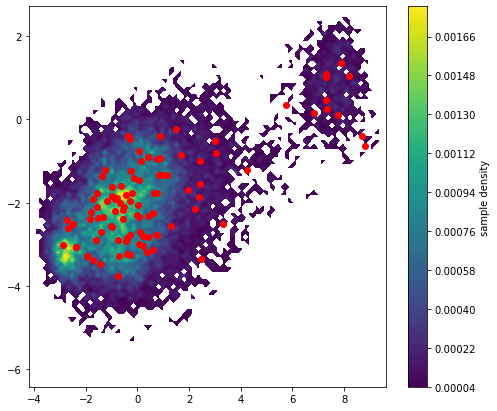

In [389]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(8,7))
pyemma.plots.plot_density(*converted_data_monomer.T[:2], ax=ax, cbar=True)
ax.scatter(*cluster_monomer.clustercenters.T[:2], c='red')
plt.show()

In [1]:
sns.reset_orig()
fig, ax = plt.subplots(figsize=(8,7))
pyemma.plots.plot_density(*pca_concatenated.T[:2], ax=ax, cbar=True)
ax.scatter(*cluster_dimer.clustercenters.T[:2], c='blue', label='dimer')

ax.scatter(*cluster_monomer.clustercenters.T[:2], c='red', label='monomer')

plt.legend()
plt.savefig('monomer-dimer.png')

NameError: name 'sns' is not defined

In [391]:
cluster_dimer = pyemma.coordinates.cluster_kmeans(pca.get_output(), k=300, max_iter=50, stride=10)

In [4]:
cluster_dimer.dtrajs

NameError: name 'cluster_dimer' is not defined